# Obrada prirodnog jezika za razumijevanje povratnih informacija klijenata u ugostiteljskoj industriji

// TODO
- probat samo stemming ne stopword removal za treniranje
- ostavit staru preprocess funkciju za nove tekstove
- spremit model na github

## Potrebni moduli

In [ ]:
import re
import os
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Učitavanje podataka

In [ ]:
# Za prikazivanje cijelih komentara postaviti na 0
pd.set_option("max_colwidth", 100)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/dsabljic/UUI-NLP-u-ugostiteljstvu/master/data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",2
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathro...,3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown s...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room ...",5


## EDA

In [ ]:
# Vrijednosti koje nedostaju
df.isna().sum()

Review    0
Rating    0
dtype: int64

In [ ]:
df.Rating.describe()

count    20491.000000
mean         3.952223
std          1.233030
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

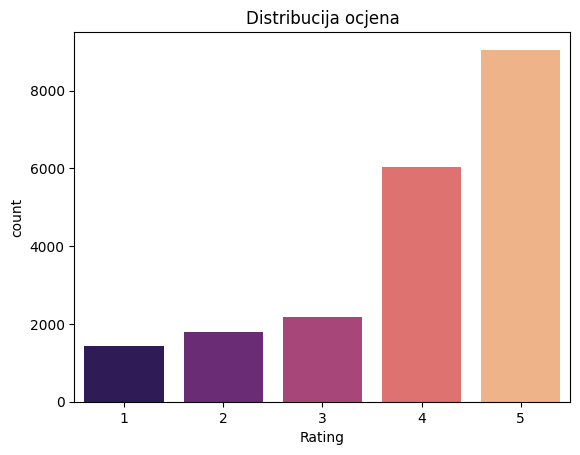

In [ ]:
# Distribucija ocjena
sns.countplot(data=df, x="Rating", palette="magma").set_title("Distribucija ocjena");

In [ ]:
# Duljina review-a (char)
df['Length'] = df['Review'].str.len()
df.head()

,Review,Rating,Length
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",4,593
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",2,1689
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathro...,3,1427
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown s...",5,600
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room ...",5,1281


In [ ]:
# Duljina review-a (riječ)
def word_count(review):
    review_list = review.split()
    return len(review_list)

df['Word count'] = df['Review'].apply(word_count)
df.head()

,Review,Rating,Length,Word count
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",4,593,87
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",2,1689,250
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathro...,3,1427,217
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown s...",5,600,89
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room ...",5,1281,191


In [ ]:
# Deskriptivna statistika
df.Length.describe()

count    20491.000000
mean       724.896833
std        689.101024
min         44.000000
25%        339.000000
50%        537.000000
75%        859.000000
max      13501.000000
Name: Length, dtype: float64

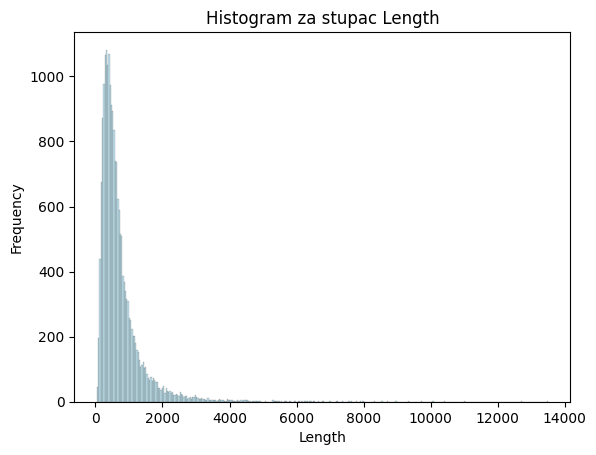

In [ ]:
sns.histplot(df['Length'], kde=False, color='lightblue')
plt.title('Histogram za stupac Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df['Word count'].describe()

count    20491.000000
mean       104.375824
std        100.656586
min          7.000000
25%         48.000000
50%         77.000000
75%        124.000000
max       1931.000000
Name: Word count, dtype: float64

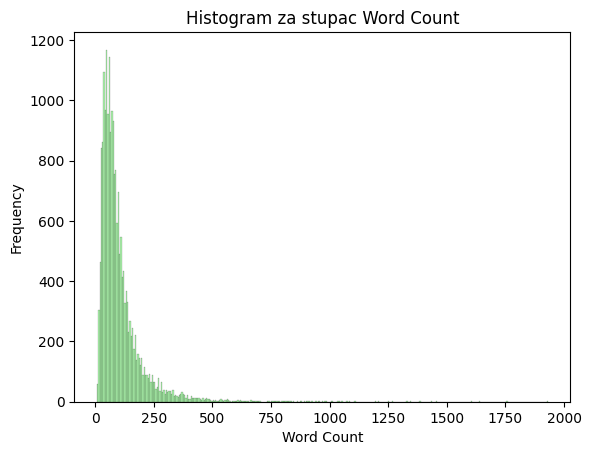

In [ ]:
sns.histplot(df['Word count'], kde=False, color='lightgreen')
plt.title('Histogram za stupac Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## Najzastupljenije riječi i *n*-grami

In [ ]:
df.drop(['Length', 'Word count'], axis = 1, inplace = True)
df.head()

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",2
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathro...,3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown s...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room ...",5


In [ ]:
def clean(review):

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review) # uklanjanje specijalnih znakova
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

In [ ]:
df['Review'] = df['Review'].apply(clean)

In [ ]:
def split_into_words(text):
    text_list = text.split()
    return text_list

df['Review_lists'] = df['Review'].apply(split_into_words)

In [ ]:
df.head()

,Review,Rating,Review_lists
0,nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advi...,4,"[nice, hotel, expensive, parking, got, good, deal, stay, hotel, anniversary, arrived, late, even..."
1,ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle star...,2,"[ok, nothing, special, charge, diamond, member, hilton, decided, chain, shot, 20th, anniversary,..."
2,nice rooms 4 experience hotel monaco seattle good hotel nt 4 levelpositives large bathroom medit...,3,"[nice, rooms, 4, experience, hotel, monaco, seattle, good, hotel, nt, 4, levelpositives, large, ..."
3,unique great stay wonderful time hotel monaco location excellent short stroll main downtown shop...,5,"[unique, great, stay, wonderful, time, hotel, monaco, location, excellent, short, stroll, main, ..."
4,great stay great stay went seahawk game awesome downfall view building nt complain room huge sta...,5,"[great, stay, great, stay, went, seahawk, game, awesome, downfall, view, building, nt, complain,..."


In [ ]:
corpus = [word for review_list in df['Review_lists'] for word in review_list]
len(corpus)

2060911

In [ ]:
most_common_words = Counter(corpus).most_common(10)
most_common_words

[('hotel', 48844),
 ('room', 34279),
 ('great', 21068),
 ('nt', 18989),
 ('good', 16953),
 ('staff', 16193),
 ('stay', 15142),
 ('nice', 12393),
 ('rooms', 12005),
 ('location', 11009)]

In [ ]:
words, freq = zip(*most_common_words)

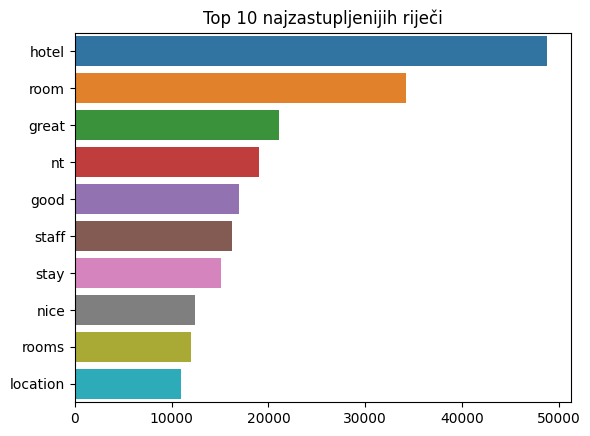

In [ ]:
sns.barplot(x=list(freq), y=list(words))
plt.title('Top 10 najzastupljenijih riječi')
plt.show()

In [ ]:
def display_ngram(n, df):
  cv = CountVectorizer(ngram_range=(n,n))
  n_gram = cv.fit_transform(df['Review'])
  count_values = n_gram.toarray().sum(axis=0)
  ngram_df = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
  ngram_df.columns = ["frequency", "ngram"]

  sns.barplot(x=ngram_df['frequency'][:10], y=ngram_df['ngram'][:10])
  plt.title('Top 10 najzastupljenijih n-grama')
  plt.show()

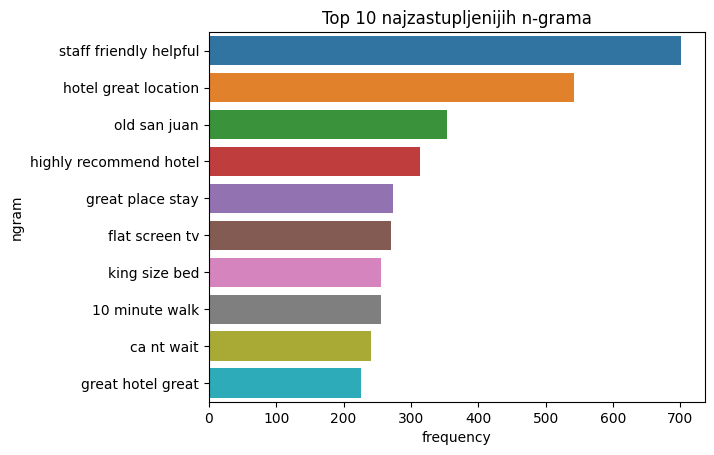

In [ ]:
n_gram = display_ngram(3, df)

## Analiza sentimenta sa sekvencijalnim modelima

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Bidirectional, Dense, Dropout, TextVectorization
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from nltk.stem.snowball import SnowballStemmer

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/dsabljic/UUI-NLP-u-ugostiteljstvu/master/data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",2
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathro...,3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown s...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room ...",5


In [ ]:
df['Label'] = df['Rating'].apply(lambda x: 0 if x in [1, 2] else (1 if x == 3 else 2)) # 0 - negativna recenzija, 1 - neutralna, 2 - pozitivna

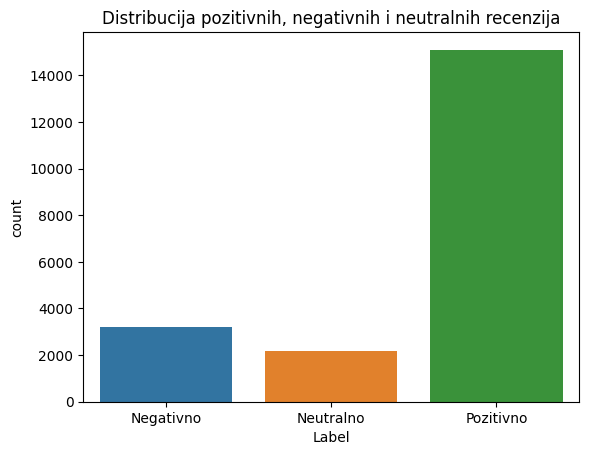

In [ ]:
sns.countplot(x='Label', data=df)
plt.title('Distribucija pozitivnih, negativnih i neutralnih recenzija')
plt.xticks(ticks=[0, 1, 2], labels=['Negativno', 'Neutralno', 'Pozitivno']);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["Review"], df["Label"], test_size=0.2, random_state=72)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=72)

In [ ]:
stop_words = set(stopwords.words('english'))
words_to_keep = {'not', 'no', 'nt', 'very'}
filtered_stop_words = stop_words - words_to_keep

stemmer = SnowballStemmer("english")

def custom_preprocessing_sw_removal(text):
    # Provjera je li tekst string i pretvaranje u string ako nije
    if not isinstance(text, str):
        text = str(text)

    # Pretvaranje teksta u mala slova
    text = text.lower()
    # Uklanjanje interpunkcije
    text = re.sub(r'[^\w\s]', '', text)
    # Stemming i uklanjanje stopwordsa osim onih koji utječu na sentiment
    text = " ".join(stemmer.stem(word) for word in text.split() if word not in filtered_stop_words)

    return text

In [ ]:
X_train = X_train.apply(custom_preprocessing_sw_removal)
X_val = X_val.apply(custom_preprocessing_sw_removal)
X_test = X_test.apply(custom_preprocessing_sw_removal)

In [ ]:
batch_size = 32
VOCAB_TOKENS = 5000

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_TOKENS)

encoder.adapt(train_ds.map(lambda text, labels: text))

np.array(encoder.get_vocabulary())[:20]

array(['', '[UNK]', 'hotel', 'room', 'not', 'stay', 'great', 'nt', 'good',
       'staff', 'night', 'locat', 'nice', 'day', 'time', 'no', 'servic',
       'clean', 'walk', 'restaur'], dtype='<U14')

In [ ]:
def plot_metrics(history):
    metrics = pd.DataFrame(history.history)
    metrics[['accuracy', 'val_accuracy']].plot()
    metrics[['loss', 'val_loss']].plot()

### *Vanilla* RNN

Epoch 1/10
385/385 [==============================] - 310s 792ms/step - loss: 0.8606 - accuracy: 0.6399 - val_loss: 0.7400 - val_accuracy: 0.7457
Epoch 2/10
385/385 [==============================] - 270s 702ms/step - loss: 0.6947 - accuracy: 0.7609 - val_loss: 0.6004 - val_accuracy: 0.7389
Epoch 3/10
385/385 [==============================] - 257s 667ms/step - loss: 0.5706 - accuracy: 0.7945 - val_loss: 0.4894 - val_accuracy: 0.8231
Epoch 4/10
385/385 [==============================] - 252s 653ms/step - loss: 0.4705 - accuracy: 0.8194 - val_loss: 0.4661 - val_accuracy: 0.8353
Epoch 5/10
385/385 [==============================] - 255s 661ms/step - loss: 0.4090 - accuracy: 0.8360 - val_loss: 0.4774 - val_accuracy: 0.8358
Epoch 6/10
385/385 [==============================] - 254s 661ms/step - loss: 0.3472 - accuracy: 0.8633 - val_loss: 0.4839 - val_accuracy: 0.8248
Epoch 7/10
385/385 [==============================] - 256s 667ms/step - loss: 0.2953 - accuracy: 0.8764 - val_loss: 0.5543 -

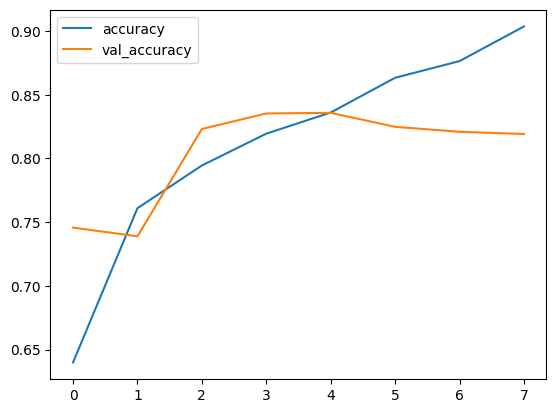

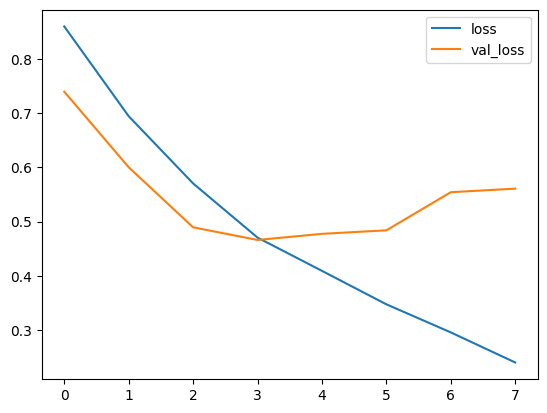

In [ ]:
rnn_model = Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    SimpleRNN(32),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')])

rnn_model.compile(optimizer=Adam(learning_rate=3e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = rnn_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = rnn_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 8s 63ms/step - loss: 0.5715 - accuracy: 0.8104
Test Loss: 0.5714691281318665
Test Accuracy: 0.8104415535926819


### GRU

Epoch 1/10
385/385 [==============================] - 43s 96ms/step - loss: 0.9631 - accuracy: 0.7626 - val_loss: 0.5947 - val_accuracy: 0.8304
Epoch 2/10
385/385 [==============================] - 21s 54ms/step - loss: 0.5562 - accuracy: 0.8359 - val_loss: 0.5198 - val_accuracy: 0.8436
Epoch 3/10
385/385 [==============================] - 16s 41ms/step - loss: 0.4795 - accuracy: 0.8539 - val_loss: 0.5327 - val_accuracy: 0.8048
Epoch 4/10
385/385 [==============================] - 14s 37ms/step - loss: 0.4318 - accuracy: 0.8625 - val_loss: 0.5186 - val_accuracy: 0.8380
Epoch 5/10
385/385 [==============================] - 13s 33ms/step - loss: 0.4030 - accuracy: 0.8685 - val_loss: 0.5003 - val_accuracy: 0.8407

Final val_accuracy: 84.07%



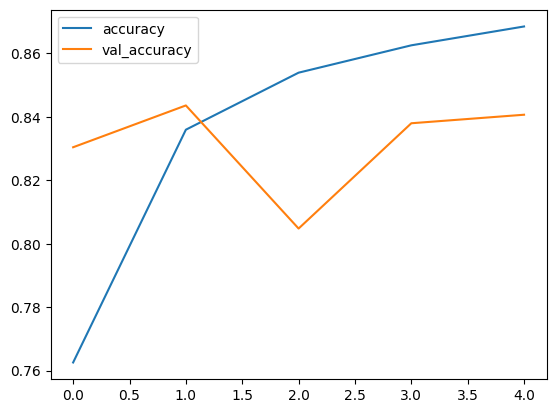

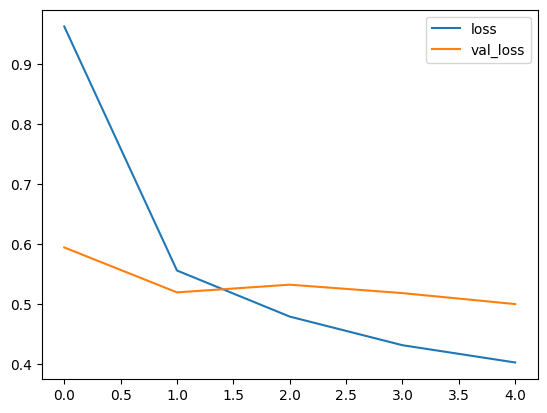

In [ ]:
gru_model = Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    GRU(32),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')])

gru_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = gru_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = gru_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 13ms/step - loss: 0.5098 - accuracy: 0.8385
Test Loss: 0.5097711086273193
Test Accuracy: 0.8384972214698792


### Dvosmjerna GRU mreža

Epoch 1/10
385/385 [==============================] - 54s 116ms/step - loss: 0.9447 - accuracy: 0.7826 - val_loss: 0.5341 - val_accuracy: 0.8258
Epoch 2/10
385/385 [==============================] - 27s 70ms/step - loss: 0.4600 - accuracy: 0.8544 - val_loss: 0.4683 - val_accuracy: 0.8348
Epoch 3/10
385/385 [==============================] - 22s 57ms/step - loss: 0.4044 - accuracy: 0.8676 - val_loss: 0.4482 - val_accuracy: 0.8424
Epoch 4/10
385/385 [==============================] - 21s 54ms/step - loss: 0.3568 - accuracy: 0.8815 - val_loss: 0.4606 - val_accuracy: 0.8455
Epoch 5/10
385/385 [==============================] - 19s 49ms/step - loss: 0.3222 - accuracy: 0.8916 - val_loss: 0.4739 - val_accuracy: 0.8455
Epoch 6/10
385/385 [==============================] - 19s 48ms/step - loss: 0.2890 - accuracy: 0.9082 - val_loss: 0.4738 - val_accuracy: 0.8453
Epoch 7/10
385/385 [==============================] - 17s 44ms/step - loss: 0.2735 - accuracy: 0.9187 - val_loss: 0.4861 - val_accuracy

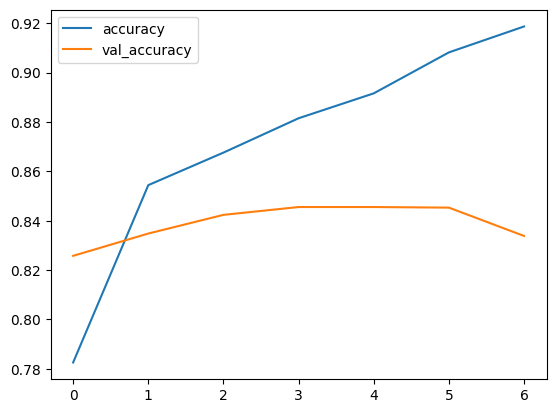

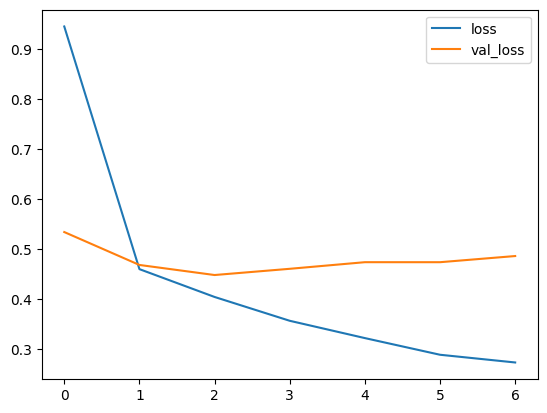

In [ ]:
bi_gru_model = tf.keras.models.Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    Bidirectional(GRU(32)),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.4),
    Dense(3, activation='softmax')])

bi_gru_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = bi_gru_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = bi_gru_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 15ms/step - loss: 0.5237 - accuracy: 0.8290
Test Loss: 0.5236755013465881
Test Accuracy: 0.8289826512336731


### LSTM

Epoch 1/10
385/385 [==============================] - 45s 102ms/step - loss: 1.0309 - accuracy: 0.7706 - val_loss: 0.6663 - val_accuracy: 0.8214
Epoch 2/10
385/385 [==============================] - 22s 57ms/step - loss: 0.6104 - accuracy: 0.7769 - val_loss: 0.5861 - val_accuracy: 0.7504
Epoch 3/10
385/385 [==============================] - 18s 45ms/step - loss: 0.5784 - accuracy: 0.7810 - val_loss: 0.5617 - val_accuracy: 0.7911
Epoch 4/10
385/385 [==============================] - 14s 36ms/step - loss: 0.4931 - accuracy: 0.8430 - val_loss: 0.5225 - val_accuracy: 0.8353
Epoch 5/10
385/385 [==============================] - 13s 35ms/step - loss: 0.4517 - accuracy: 0.8564 - val_loss: 0.5307 - val_accuracy: 0.8045
Epoch 6/10
385/385 [==============================] - 12s 30ms/step - loss: 0.4288 - accuracy: 0.8637 - val_loss: 0.5077 - val_accuracy: 0.8285
Epoch 7/10
385/385 [==============================] - 11s 29ms/step - loss: 0.3965 - accuracy: 0.8707 - val_loss: 0.5186 - val_accuracy

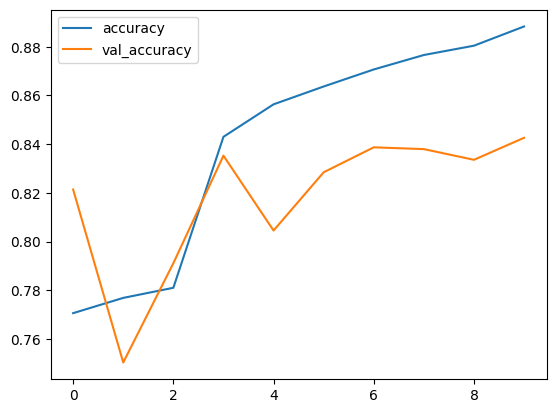

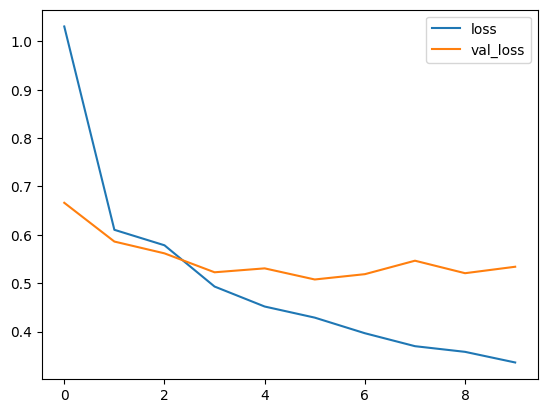

In [ ]:
lstm_model = tf.keras.models.Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    LSTM(64),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')])

lstm_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = lstm_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = lstm_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 1s 10ms/step - loss: 0.5547 - accuracy: 0.8341
Test Loss: 0.5547009706497192
Test Accuracy: 0.834105908870697


### Dvosmjerni LSTM

Epoch 1/20
385/385 [==============================] - 56s 124ms/step - loss: 1.0329 - accuracy: 0.8013 - val_loss: 0.5119 - val_accuracy: 0.8450
Epoch 2/20
385/385 [==============================] - 27s 71ms/step - loss: 0.4876 - accuracy: 0.8552 - val_loss: 0.4845 - val_accuracy: 0.8321
Epoch 3/20
385/385 [==============================] - 24s 61ms/step - loss: 0.4412 - accuracy: 0.8651 - val_loss: 0.4552 - val_accuracy: 0.8533
Epoch 4/20
385/385 [==============================] - 21s 55ms/step - loss: 0.4447 - accuracy: 0.8639 - val_loss: 0.5167 - val_accuracy: 0.8411
Epoch 5/20
385/385 [==============================] - 19s 49ms/step - loss: 0.3899 - accuracy: 0.8738 - val_loss: 0.4476 - val_accuracy: 0.8538
Epoch 6/20
385/385 [==============================] - 19s 48ms/step - loss: 0.3641 - accuracy: 0.8859 - val_loss: 0.4576 - val_accuracy: 0.8533
Epoch 7/20
385/385 [==============================] - 17s 45ms/step - loss: 0.3240 - accuracy: 0.9013 - val_loss: 0.4762 - val_accuracy

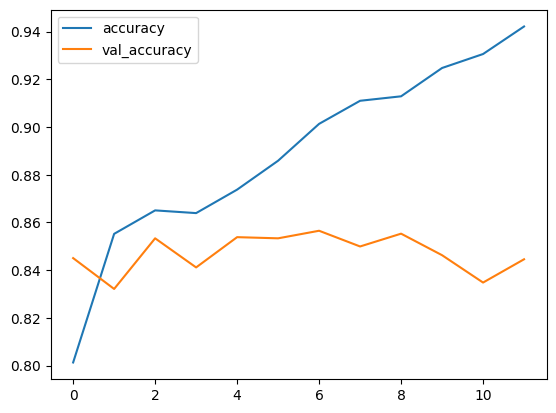

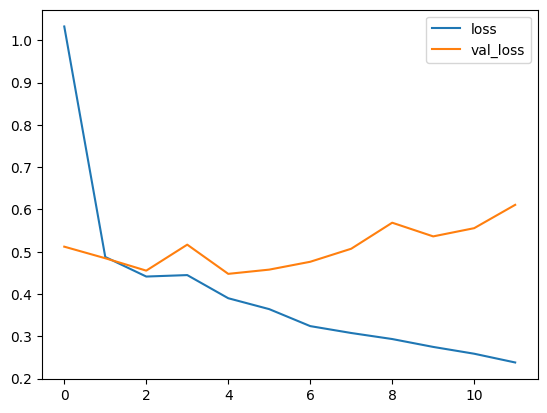

In [ ]:
bi_lstm_model = tf.keras.models.Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')])

bi_lstm_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = bi_lstm_model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = bi_lstm_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 18ms/step - loss: 0.6569 - accuracy: 0.8368
Test Loss: 0.6568777561187744
Test Accuracy: 0.8367894887924194


### GloVe

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2024-01-14 12:49:38--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-14 12:49:38--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2024-01-14 12:52:18 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
glove_path = './glove.6B.100d.txt'

embeddings_index = {}
with open(glove_path, 'r', encoding='utf8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

In [ ]:
vocab = encoder.get_vocabulary()
embedding_dim = 100
embedding_matrix = np.zeros((len(vocab), embedding_dim))

for i, word in enumerate(vocab):
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim, ))

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(vocab),
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)

In [ ]:
# Prve riječi u vokabularu
for i, word in enumerate(vocab):
  print(i)
  print(word)
  if i == 5:
    break

0

1
[UNK]
2
hotel
3
room
4
not
5
stay


#### BiLSTM model sa GloVe vektorima

Epoch 1/10
385/385 [==============================] - 18s 37ms/step - loss: 1.1995 - accuracy: 0.7428 - val_loss: 0.6799 - val_accuracy: 0.7677
Epoch 2/10
385/385 [==============================] - 13s 33ms/step - loss: 0.6355 - accuracy: 0.7918 - val_loss: 0.5802 - val_accuracy: 0.8158
Epoch 3/10
385/385 [==============================] - 13s 33ms/step - loss: 0.5703 - accuracy: 0.8093 - val_loss: 0.5126 - val_accuracy: 0.8324
Epoch 4/10
385/385 [==============================] - 13s 33ms/step - loss: 0.5482 - accuracy: 0.8205 - val_loss: 0.5333 - val_accuracy: 0.8133
Epoch 5/10
385/385 [==============================] - 13s 33ms/step - loss: 0.4988 - accuracy: 0.8333 - val_loss: 0.4878 - val_accuracy: 0.8263
Epoch 6/10
385/385 [==============================] - 12s 32ms/step - loss: 0.4756 - accuracy: 0.8435 - val_loss: 0.4715 - val_accuracy: 0.8448
Epoch 7/10
385/385 [==============================] - 13s 32ms/step - loss: 0.4538 - accuracy: 0.8480 - val_loss: 0.4584 - val_accuracy:

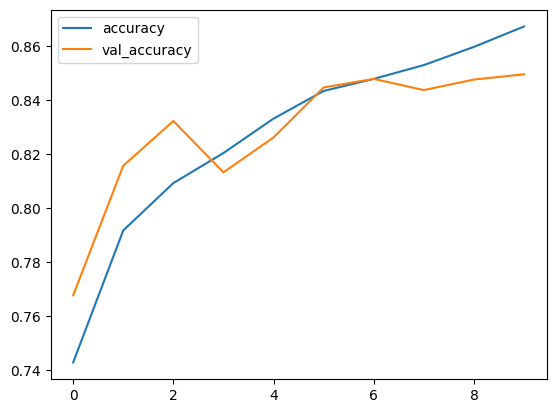

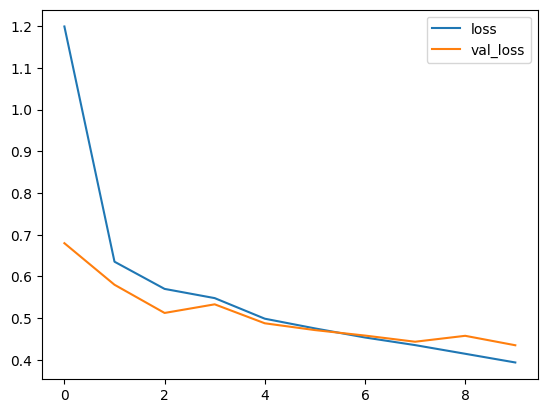

In [ ]:
bi_lstm_model_glove = tf.keras.models.Sequential([
    encoder,
    embedding_layer,
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')])

bi_lstm_model_glove.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = bi_lstm_model_glove.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = bi_lstm_model_glove.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 14ms/step - loss: 0.4407 - accuracy: 0.8548
Test Loss: 0.4407152533531189
Test Accuracy: 0.8548426628112793


#### BiGRU model sa GloVe vektorima

In [ ]:
!mkdir models

In [ ]:
checkpoint_path = "models/gru_glove.ckpt"

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                monitor="val_loss", mode="min",
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=1)

Epoch 1/25
384/385 [============================>.] - ETA: 0s - loss: 0.6659 - accuracy: 0.7476
Epoch 1: val_loss improved from inf to 0.53862, saving model to models/gru_glove.ckpt
385/385 [==============================] - 18s 35ms/step - loss: 0.6658 - accuracy: 0.7477 - val_loss: 0.5386 - val_accuracy: 0.8058
Epoch 2/25
385/385 [==============================] - ETA: 0s - loss: 0.5115 - accuracy: 0.8113
Epoch 2: val_loss improved from 0.53862 to 0.43024, saving model to models/gru_glove.ckpt
385/385 [==============================] - 12s 32ms/step - loss: 0.5115 - accuracy: 0.8113 - val_loss: 0.4302 - val_accuracy: 0.8392
Epoch 3/25
383/385 [============================>.] - ETA: 0s - loss: 0.4405 - accuracy: 0.8366
Epoch 3: val_loss improved from 0.43024 to 0.42728, saving model to models/gru_glove.ckpt
385/385 [==============================] - 12s 31ms/step - loss: 0.4403 - accuracy: 0.8366 - val_loss: 0.4273 - val_accuracy: 0.8341
Epoch 4/25
384/385 [===========================

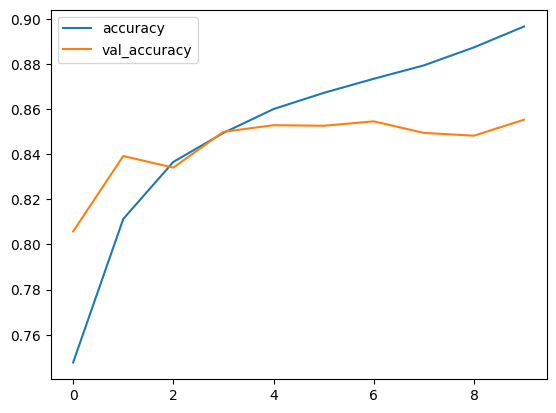

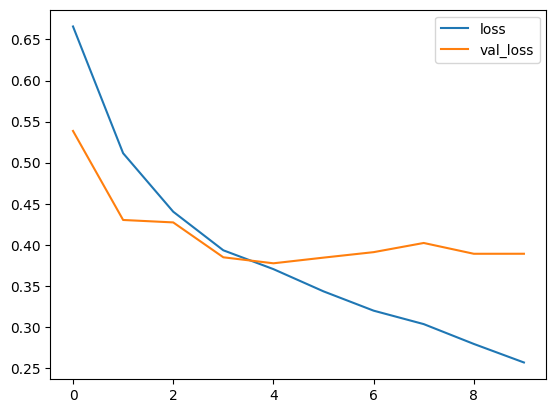

In [ ]:
gru_model_glove1 = tf.keras.models.Sequential([
    encoder,
    embedding_layer,
    Bidirectional(GRU(64)),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

gru_model_glove1.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = gru_model_glove1.fit(train_ds, epochs=25, validation_data=val_ds, callbacks=[early_stopping, checkpoint])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

#### Evaluacija modela

In [ ]:
test_loss, test_acc = gru_model_glove1.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 14ms/step - loss: 0.4101 - accuracy: 0.8612
Test Loss: 0.4100740849971771
Test Accuracy: 0.8611856698989868


In [ ]:
y_pred = gru_model_glove1.predict(X_test)
y_pred = tf.argmax(y_pred, axis=1).numpy()

129/129 [==============================] - 3s 17ms/step


In [ ]:
# Matrica konfuzije
conf_matrix = confusion_matrix(y_test, y_pred)

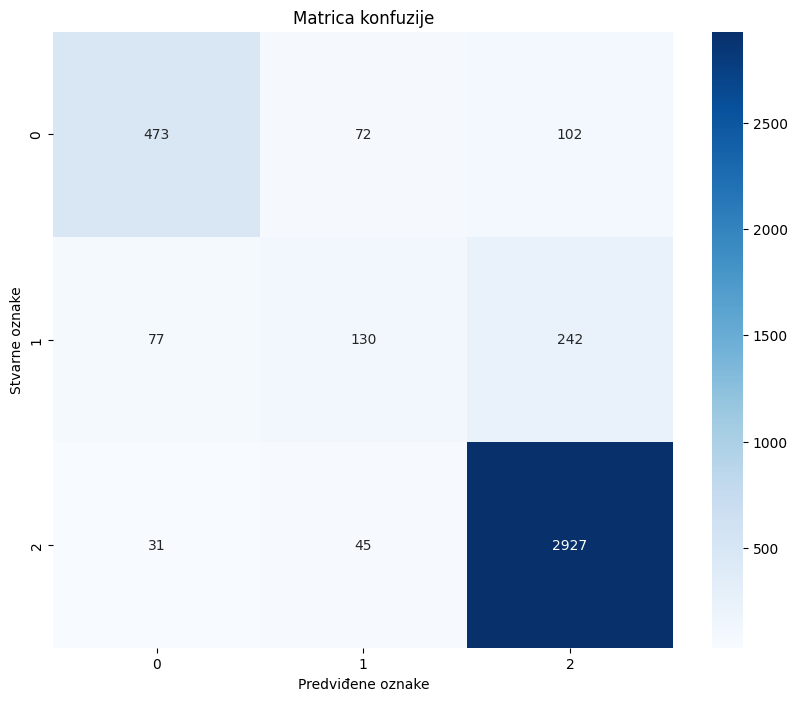

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predviđene oznake')
plt.ylabel('Stvarne oznake')
plt.title('Matrica konfuzije')
plt.show()

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose().round(2)

In [ ]:
df_report

,precision,recall,f1-score,support
0,0.81,0.73,0.77,647.00
1,0.53,0.29,0.37,449.00
2,0.89,0.97,0.93,3003.00
accuracy,0.86,0.86,0.86,0.86
macro avg,0.75,0.67,0.69,4099.00
weighted avg,0.84,0.86,0.85,4099.00


### Primjer klasifikacije komentara

Sada možemo definirati model iste strukture kao `gru_model_glove1` i vratiti težine iz epohe s najboljim performansom (najmanji *loss* u ovom slučaju).

In [ ]:
gru_model_glove = tf.keras.models.Sequential([
    encoder,
    embedding_layer,
    Bidirectional(GRU(64)),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')])

gru_model_glove.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
gru_model_glove.load_weights(checkpoint_path)

In [ ]:
test_loss, test_acc = gru_model_glove.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 4s 19ms/step - loss: 0.3823 - accuracy: 0.8529
Test Loss: 0.3822999596595764
Test Accuracy: 0.8528909683227539


In [ ]:
def classify_comment(comment, model):
    labels = ['Negative', 'Neutral', 'Positive']
    # Ručno pretprocesiranje komentara
    preprocessed_comment = custom_preprocessing_sw_removal(comment)
    # Pretvaranje u TensorFlow Dataset
    ds = tf.data.Dataset.from_tensor_slices([preprocessed_comment])
    ds = ds.batch(1)
    # Predviđanje
    prediction = model.predict(ds)
    return labels[np.argmax(prediction)]

In [ ]:
comment = "I was very disappointed with my stay. The room was dirty and the service was unacceptably slow."
prediction = classify_comment(comment, gru_model_glove)
print(f"Predicted Sentiment: {prediction}\n")

1/1 [==============================] - 1s 611ms/step
Predicted Sentiment: Negative



In [ ]:
# Komentari/recenzije
positive = ["This hotel exceeded all my expectations, the staff were incredibly helpful and the location was perfect.",
            "Absolutely loved my stay here! The rooms were clean, spacious, and well-equipped.",
            "Fantastic experience! The food was gourmet quality and the service was top-notch."]

negative = ["I was very disappointed with my stay. The room was dirty and the service was unacceptably slow.",
            "Terrible experience. The hotel was noisy, and the staff were rude and unhelpful.",
            "Not worth the price. The facilities were outdated and the bed was uncomfortable."]

In [ ]:
for comment in positive + negative:
    print(f"Original Comment: {comment}")
    pred = classify_comment(comment, gru_model_glove)
    print(f"Predicted Sentiment: {pred}\n")
    print()

Original Comment: This hotel exceeded all my expectations, the staff were incredibly helpful and the location was perfect.
1/1 [==============================] - 0s 9ms/step
Predicted Sentiment: Positive


Original Comment: Absolutely loved my stay here! The rooms were clean, spacious, and well-equipped.
1/1 [==============================] - 0s 10ms/step
Predicted Sentiment: Positive


Original Comment: Fantastic experience! The food was gourmet quality and the service was top-notch.
1/1 [==============================] - 0s 11ms/step
Predicted Sentiment: Positive


Original Comment: I was very disappointed with my stay. The room was dirty and the service was unacceptably slow.
1/1 [==============================] - 0s 8ms/step
Predicted Sentiment: Negative


Original Comment: Terrible experience. The hotel was noisy, and the staff were rude and unhelpful.
1/1 [==============================] - 0s 7ms/step
Predicted Sentiment: Negative


Original Comment: Not worth the price. The faci